In [1]:
!pip install transformers pandas torch


  Using cached transformers-4.42.4-py3-none-any.whl (9.3 MB)
  Using cached safetensors-0.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached huggingface_hub-0.23.5-py3-none-any.whl (402 kB)
  Using cached regex-2024.5.15-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (774 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import pandas as pd
import os

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')
df.head()


,label,Tweets
0,1,مصروف فلپس ایک کارکردگی، مزاحیہ اور ڈرامائی دو...
1,0,ایک comely آہستہ ہپپی (Kay کے لینز) اور ان کے ...
2,0,"الزبتھ وارڈ Gracen، شاید صرف بل کلنٹن کی ""Bimb..."
3,1,ایک مقبول کھیل کے طور پر، سرفنگ بہت سے لوگوں ک...
4,1,"ایڈورڈ Dmytryk کی ""فائرنگ"" ایک نایاب فلم 1940s..."


In [3]:
# Reset index to avoid KeyError issues
df = df.reset_index(drop=True)


In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [14]:
import numpy as np

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()


Epoch 1/15
----------
Train loss 0.6969861725034813 accuracy 0.5097815454841865
Val   loss 0.6916682490458091 accuracy 0.5143415906127771

Epoch 2/15
----------
Train loss 0.6953069319327673 accuracy 0.5060319530485816
Val   loss 0.7044368758797646 accuracy 0.5143415906127771

Epoch 3/15
----------
Train loss 0.6952424802196523 accuracy 0.5026084121291164
Val   loss 0.6979990800221761 accuracy 0.48565840938722293

Epoch 4/15
----------
Train loss 0.6869892154354602 accuracy 0.5498858819693512
Val   loss 0.6748971970131 accuracy 0.5834419817470665

Epoch 5/15
----------
Train loss 0.6505744164654365 accuracy 0.6170524942940985
Val   loss 0.6478095259517431 accuracy 0.6264667535853976

Epoch 6/15
----------
Train loss 0.6045348878639439 accuracy 0.6776980762960547
Val   loss 0.6069822867090503 accuracy 0.6773142112125162

Epoch 7/15
----------
Train loss 0.5723914237072071 accuracy 0.704271274861428
Val   loss 0.6016637564947208 accuracy 0.6773142112125162

Epoch 8/15
----------
Train lo

In [15]:
model.save_pretrained('BERT-CASED')
tokenizer.save_pretrained('BERT-CASED-tokenizer')


('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

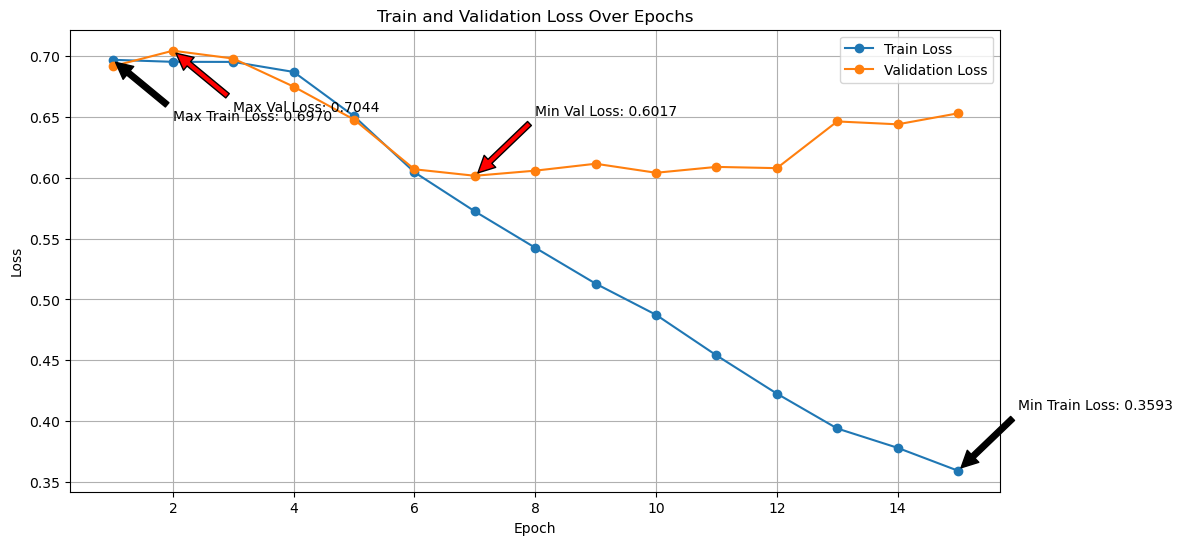

    Epoch  Train Loss  Val Loss  Train Accuracy  Val Accuracy
0       1    0.696986  0.691668        0.509782      0.514342
1       2    0.695307  0.704437        0.506032      0.514342
2       3    0.695242  0.697999        0.502608      0.485658
3       4    0.686989  0.674897        0.549886      0.583442
4       5    0.650574  0.647810        0.617052      0.626467
5       6    0.604535  0.606982        0.677698      0.677314
6       7    0.572391  0.601664        0.704271      0.677314
7       8    0.542487  0.605869        0.733127      0.675359
8       9    0.513000  0.611557        0.753668      0.704042
9      10    0.487396  0.604137        0.768829      0.704694
10     11    0.454077  0.608957        0.792142      0.711864
11     12    0.422632  0.607929        0.815455      0.709257
12     13    0.393964  0.646320        0.827030      0.708605
13     14    0.378080  0.643958        0.838768      0.710561
14     15    0.359264  0.652987        0.851321      0.710561


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Epoch": list(range(1, 16)),
    "Train Loss": [
        0.6969861725034813, 0.6953069319327673, 0.6952424802196523, 0.6869892154354602, 
        0.6505744164654365, 0.6045348878639439, 0.5723914237072071, 0.5424868074478582, 
        0.5129996423299114, 0.4873963533124576, 0.45407698264655966, 0.4226322503721652, 
        0.39396424607063335, 0.3780804989898267, 0.35926375198566046
    ],
    "Val Loss": [
        0.6916682490458091, 0.7044368758797646, 0.6979990800221761, 0.6748971970131, 
        0.6478095259517431, 0.6069822867090503, 0.6016637564947208, 0.6058687226225933, 
        0.6115565543683866, 0.6041370049739877, 0.6089571729923288, 0.6079292671444515, 
        0.6463201182583967, 0.6439577294513583, 0.6529872822575271
    ],
    "Train Accuracy": [
        0.5097815454841865, 0.5060319530485816, 0.5026084121291164, 0.5498858819693512, 
        0.6170524942940985, 0.6776980762960547, 0.704271274861428, 0.7331268340397783, 
        0.7536680795565699, 0.768829475057059, 0.7921421584610369, 0.8154548418650147, 
        0.8270296706879687, 0.8387675252689925, 0.8513205086403651
    ],
    "Val Accuracy": [
        0.5143415906127771, 0.5143415906127771, 0.48565840938722293, 0.5834419817470665, 
        0.6264667535853976, 0.6773142112125162, 0.6773142112125162, 0.6753585397653195, 
        0.7040417209908735, 0.7046936114732725, 0.711864406779661, 0.7092568448500651, 
        0.7086049543676662, 0.7105606258148631, 0.7105606258148631
    ]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss", marker='o')
plt.plot(df["Epoch"], df["Val Loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Annotating min and max points for train loss
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', 
             xy=(df["Epoch"][df["Train Loss"].idxmin()], df["Train Loss"].min()), 
             xytext=(df["Epoch"][df["Train Loss"].idxmin()] + 1, df["Train Loss"].min() + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Loss: {df["Train Loss"].max():.4f}', 
             xy=(df["Epoch"][df["Train Loss"].idxmax()], df["Train Loss"].max()), 
             xytext=(df["Epoch"][df["Train Loss"].idxmax()] + 1, df["Train Loss"].max() - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotating min and max points for val loss
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', 
             xy=(df["Epoch"][df["Val Loss"].idxmin()], df["Val Loss"].min()), 
             xytext=(df["Epoch"][df["Val Loss"].idxmin()] + 1, df["Val Loss"].min() + 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate(f'Max Val Loss: {df["Val Loss"].max():.4f}', 
             xy=(df["Epoch"][df["Val Loss"].idxmax()], df["Val Loss"].max()), 
             xytext=(df["Epoch"][df["Val Loss"].idxmax()] + 1, df["Val Loss"].max() - 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

# Display the DataFrame
print(df)


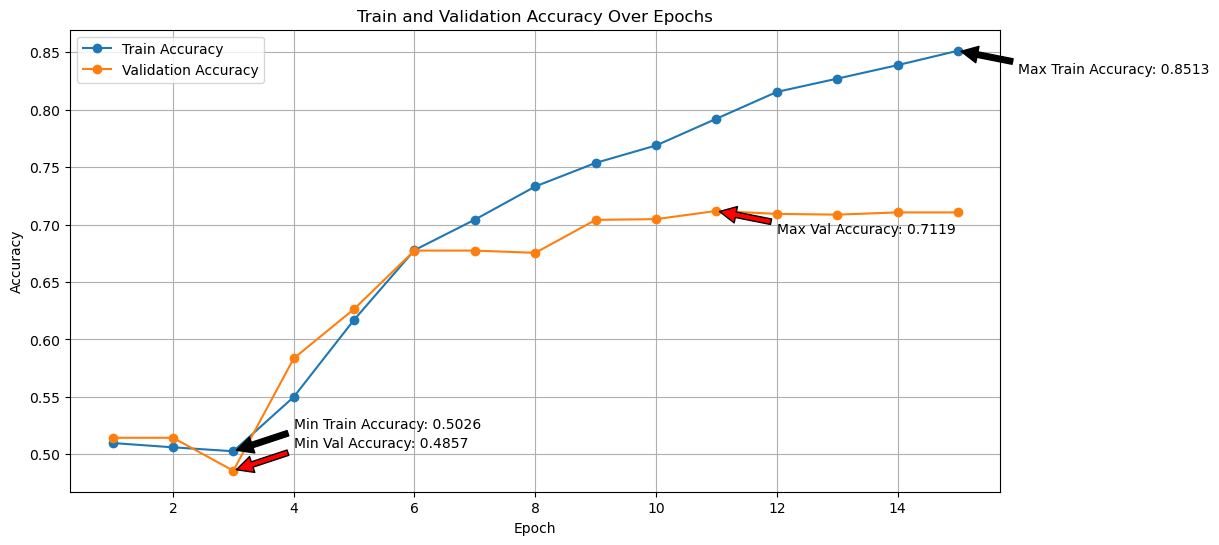

    Epoch  Train Loss  Val Loss  Train Accuracy  Val Accuracy
0       1    0.696986  0.691668        0.509782      0.514342
1       2    0.695307  0.704437        0.506032      0.514342
2       3    0.695242  0.697999        0.502608      0.485658
3       4    0.686989  0.674897        0.549886      0.583442
4       5    0.650574  0.647810        0.617052      0.626467
5       6    0.604535  0.606982        0.677698      0.677314
6       7    0.572391  0.601664        0.704271      0.677314
7       8    0.542487  0.605869        0.733127      0.675359
8       9    0.513000  0.611557        0.753668      0.704042
9      10    0.487396  0.604137        0.768829      0.704694
10     11    0.454077  0.608957        0.792142      0.711864
11     12    0.422632  0.607929        0.815455      0.709257
12     13    0.393964  0.646320        0.827030      0.708605
13     14    0.378080  0.643958        0.838768      0.710561
14     15    0.359264  0.652987        0.851321      0.710561


In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Train and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(df["Epoch"], df["Train Accuracy"], label="Train Accuracy", marker='o')
plt.plot(df["Epoch"], df["Val Accuracy"], label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Annotating min and max points for train accuracy
plt.annotate(f'Min Train Accuracy: {df["Train Accuracy"].min():.4f}', 
             xy=(df["Epoch"][df["Train Accuracy"].idxmin()], df["Train Accuracy"].min()), 
             xytext=(df["Epoch"][df["Train Accuracy"].idxmin()] + 1, df["Train Accuracy"].min() + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', 
             xy=(df["Epoch"][df["Train Accuracy"].idxmax()], df["Train Accuracy"].max()), 
             xytext=(df["Epoch"][df["Train Accuracy"].idxmax()] + 1, df["Train Accuracy"].max() - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotating min and max points for val accuracy
plt.annotate(f'Min Val Accuracy: {df["Val Accuracy"].min():.4f}', 
             xy=(df["Epoch"][df["Val Accuracy"].idxmin()], df["Val Accuracy"].min()), 
             xytext=(df["Epoch"][df["Val Accuracy"].idxmin()] + 1, df["Val Accuracy"].min() + 0.02),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', 
             xy=(df["Epoch"][df["Val Accuracy"].idxmax()], df["Val Accuracy"].max()), 
             xytext=(df["Epoch"][df["Val Accuracy"].idxmax()] + 1, df["Val Accuracy"].max() - 0.02),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.show()

# Display the DataFrame
print(df)


In [21]:
!pip install safetensors

In [25]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load your saved model and tokenizer
model_path = 'path_to_save_model'
tokenizer_path = 'path_to_save_tokenizer'

model = BertForSequenceClassification.from_pretrained(model_path, use_safetensors=True)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluate on test data
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')


Test loss 0.5392156832127107 accuracy 0.7688966116420504


In [26]:
# Print the size of the test dataset
print(f'Test dataset size: {len(test_texts)}')

Test dataset size: 1151


In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 200
WEIGHT_DECAY = 0.01

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

# Evaluate on test data
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save model and tokenizer
model.save_pretrained('path_to_save_model')
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6879640876182488 accuracy 0.5340040991242779
Val   loss 0.6588711332943704 accuracy 0.5956521739130435

Epoch 2/10
----------
Train loss 0.6366498676971311 accuracy 0.6292155766722564
Val   loss 0.5802511105106937 accuracy 0.7017391304347826

Epoch 3/10
----------
Train loss 0.521644904810403 accuracy 0.7374697223774921
Val   loss 0.5760632728536924 accuracy 0.7130434782608696

Epoch 4/10
----------
Train loss 0.4032689396158925 accuracy 0.8242966275386622
Val   loss 0.646524264373713 accuracy 0.6991304347826087

Epoch 5/10
----------
Train loss 0.2582833897377852 accuracy 0.8969629215576672
Val   loss 0.7024351824074984 accuracy 0.7234782608695652

Epoch 6/10
----------
Train loss 0.1384355836697588 accuracy 0.9487609465250605
Val   loss 0.7434955512483915 accuracy 0.7078260869565217

Epoch 7/10
----------
Train loss 0.08763248305712339 accuracy 0.970933482392398
Val   loss 1.0527273139192 accuracy 0.72

Epoch 8/10
----------
Train loss 0.04369264311

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 200
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.3

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BERT_tokenzier')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.693116528292497 accuracy 0.5217067262902925
Val   loss 0.6449173837900162 accuracy 0.6408695652173914

Epoch 2/10
----------
Train loss 0.626800272436369 accuracy 0.6536239985094093
Val   loss 0.5802708835237556 accuracy 0.7078260869565217

Epoch 3/10
----------
Train loss 0.5297564921811933 accuracy 0.7361654555617664
Val   loss 0.5644036817053953 accuracy 0.7078260869565217

Epoch 4/10
----------
Train loss 0.42535959587742883 accuracy 0.8030557108254146
Val   loss 0.5991926621645689 accuracy 0.7260869565217392

Epoch 5/10
----------
Train loss 0.31798135963756413 accuracy 0.8578349170858953
Val   loss 0.680660190888577 accuracy 0.7382608695652174

Early stopping
Test loss 0.5409261182778411 accuracy 0.73501303214596


('BERT_tokenzier/tokenizer_config.json',
 'BERT_tokenzier/special_tokens_map.json',
 'BERT_tokenzier/vocab.txt',
 'BERT_tokenzier/added_tokens.json')

In [8]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)  # Change to float for BCEWithLogitsLoss
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 200
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.3

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=1)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)
        return logits

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

# Change the loss function to BCEWithLogitsLoss
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits.view(-1), labels)

        preds = torch.round(torch.sigmoid(logits))
        correct_predictions += torch.sum(preds.view(-1) == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits.view(-1), labels)

            preds = torch.round(torch.sigmoid(logits))
            correct_predictions += torch.sum(preds.view(-1) == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BCE_loss_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6971865860479218 accuracy 0.5030743432084963
Val   loss 0.6976194373435445 accuracy 0.49130434782608695

Epoch 2/10
----------
Train loss 0.694127527376016 accuracy 0.5086640581330352
Val   loss 0.6936951221691238 accuracy 0.49130434782608695

Epoch 3/10
----------
Train loss 0.6943611307513147 accuracy 0.5019564002235886
Val   loss 0.6965796127915382 accuracy 0.49130434782608695

Epoch 4/10
----------
Train loss 0.6934305612175238 accuracy 0.5176076020122974
Val   loss 0.6945306973324882 accuracy 0.5086956521739131

Early stopping
Test loss 0.6918024412459798 accuracy 0.524761077324066


('BCE_loss_tokenizer/tokenizer_config.json',
 'BCE_loss_tokenizer/special_tokens_map.json',
 'BCE_loss_tokenizer/vocab.txt',
 'BCE_loss_tokenizer/added_tokens.json')

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 200
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.3

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 3  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BERT_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6911341237525145 accuracy 0.5306502701695547
Val   loss 0.6875849771830771 accuracy 0.5208695652173914

Epoch 2/10
----------
Train loss 0.6437058470078877 accuracy 0.6260480715483511
Val   loss 0.64935831228892 accuracy 0.5930434782608696

Epoch 3/10
----------
Train loss 0.5608976277567091 accuracy 0.7106390907397055
Val   loss 0.5786014820138613 accuracy 0.7069565217391305

Epoch 4/10
----------
Train loss 0.4691924264077984 accuracy 0.7751071362027203
Val   loss 0.551488718845778 accuracy 0.74

Epoch 5/10
----------
Train loss 0.3598411515621202 accuracy 0.8343581144028321
Val   loss 0.6279245013785031 accuracy 0.72

Epoch 6/10
----------
Train loss 0.26045550502437564 accuracy 0.8855971678777715
Val   loss 0.7555507487720914 accuracy 0.7382608695652174

Epoch 7/10
----------
Train loss 0.1870574724383741 accuracy 0.9200670765790945
Val   loss 0.9888974239842759 accuracy 0.7391304347826088

Early stopping
Test loss 0.5309793789767556 accuracy 0.74

('BERT_tokenizer/tokenizer_config.json',
 'BERT_tokenizer/special_tokens_map.json',
 'BERT_tokenizer/vocab.txt',
 'BERT_tokenizer/added_tokens.json')

In [11]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.3

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 3  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BERT_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6936470759766442 accuracy 0.524128936090926
Val   loss 0.6859463113877509 accuracy 0.5591304347826087

Epoch 2/10
----------
Train loss 0.6484333027508997 accuracy 0.6150549655300913
Val   loss 0.6054862609340085 accuracy 0.6695652173913044

Epoch 3/10
----------
Train loss 0.5527460214992365 accuracy 0.7147382150177007
Val   loss 0.555200474957625 accuracy 0.7078260869565217

Epoch 4/10
----------
Train loss 0.45380250260322574 accuracy 0.786659213713434
Val   loss 0.5881015070610576 accuracy 0.7147826086956522

Epoch 5/10
----------
Train loss 0.3462102554649824 accuracy 0.8438606297745481
Val   loss 0.6905306815687153 accuracy 0.7173913043478262

Epoch 6/10
----------
Train loss 0.2439784881592329 accuracy 0.8937954164337618
Val   loss 0.8390817942304744 accuracy 0.7121739130434783

Epoch 00006: reducing learning rate of group 0 to 8.0000e-07.
Early stopping
Test loss 0.5544326988359293 accuracy 0.7219808861859253


('BERT_tokenizer/tokenizer_config.json',
 'BERT_tokenizer/special_tokens_map.json',
 'BERT_tokenizer/vocab.txt',
 'BERT_tokenizer/added_tokens.json')

In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5  # Lower initial learning rate
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.4  # Increased dropout rate

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BERT_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.689053545572928 accuracy 0.5252468790758338
Val   loss 0.6701158376203643 accuracy 0.5634782608695652

Epoch 2/10
----------
Train loss 0.6223417959575143 accuracy 0.6467300167691448
Val   loss 0.6569851222965453 accuracy 0.611304347826087

Epoch 3/10
----------
Train loss 0.5444260283949829 accuracy 0.7113843860629775
Val   loss 0.5334590031868882 accuracy 0.7373913043478261

Epoch 4/10
----------
Train loss 0.47534642639082103 accuracy 0.767281535308366
Val   loss 0.5303698968556192 accuracy 0.7208695652173913

Epoch 5/10
----------
Train loss 0.40245883845325026 accuracy 0.795789081423514
Val   loss 0.5981410619699292 accuracy 0.7295652173913044

Epoch 6/10
----------
Train loss 0.3407088693098298 accuracy 0.8386435625116452
Val   loss 0.6224692834334241 accuracy 0.7373913043478261

Epoch 7/10
----------
Train loss 0.28303956967734156 accuracy 0.8600708030557108
Val   loss 0.680336385137505 accuracy 0.7321739130434783

Epoch 8/10
----------
Train l

('BERT_tokenizer/tokenizer_config.json',
 'BERT_tokenizer/special_tokens_map.json',
 'BERT_tokenizer/vocab.txt',
 'BERT_tokenizer/added_tokens.json')

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.4

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# Initialize DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6867477915116719 accuracy 0.5507732438978945
Val   loss 0.6604724104205767 accuracy 0.6121739130434782

Epoch 2/10
----------
Train loss 0.6269921687032495 accuracy 0.640953978013788
Val   loss 0.5720653980970383 accuracy 0.6991304347826087

Epoch 3/10
----------
Train loss 0.5421194687840485 accuracy 0.718651015464878
Val   loss 0.5417799051437113 accuracy 0.7208695652173913

Epoch 4/10
----------
Train loss 0.4915422878361174 accuracy 0.7514440096888392
Val   loss 0.5672738556232717 accuracy 0.7086956521739131

Epoch 5/10
----------
Train loss 0.41273450709524606 accuracy 0.7963480529159679
Val   loss 0.6668571295837561 accuracy 0.6695652173913044

Epoch 6/10
----------
Train loss 0.36037314536848236 accuracy 0.8203838270914849
Val   loss 0.6153321380002631 accuracy 0.7226086956521739

Epoch 7/10
----------
Train loss 0.29037313673290466 accuracy 0.8475871063909074
Val   loss 0.7263538806388775 accuracy 0.7217391304347827

Epoch 00007: reducing lear

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.5  # Increased dropout rate

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# Initialize DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with dropout
class CustomBERTModel(torch.nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
        self.dropout = torch.nn.Dropout(dropout_prob)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.logits)
        return pooled_output

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('BERT_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6893778051294032 accuracy 0.5274827650456493
Val   loss 0.6473154036535157 accuracy 0.631304347826087

Epoch 2/10
----------
Train loss 0.6304347180717048 accuracy 0.6294019005030743
Val   loss 0.5658450085255835 accuracy 0.7243478260869566

Epoch 3/10
----------
Train loss 0.558461762742982 accuracy 0.6897708216880939
Val   loss 0.5339819495048788 accuracy 0.7234782608695652

Epoch 4/10
----------
Train loss 0.5000564149093061 accuracy 0.722936463573691
Val   loss 0.5374440414210161 accuracy 0.7286956521739131

Epoch 5/10
----------
Train loss 0.4502549637996015 accuracy 0.7607602012297373
Val   loss 0.5409121964540746 accuracy 0.7269565217391305

Epoch 6/10
----------
Train loss 0.3955067682213017 accuracy 0.7883361281907956
Val   loss 0.5989082172099087 accuracy 0.7304347826086957

Epoch 7/10
----------
Train loss 0.3343155712022313 accuracy 0.8116266070430408
Val   loss 0.6642975196656253 accuracy 0.7173913043478262

Epoch 00007: reducing learning

('BERT_tokenizer/tokenizer_config.json',
 'BERT_tokenizer/special_tokens_map.json',
 'BERT_tokenizer/vocab.txt',
 'BERT_tokenizer/added_tokens.json')

In [18]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.5

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# Initialize DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with an additional linear layer
class CustomBERTModel(nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.output = nn.Linear(self.bert.config.hidden_size, 2)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]  # This is the pooled output (CLS token)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.linear(pooled_output)
        pooled_output = torch.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.output(pooled_output)
        return logits

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.6927994915417263 accuracy 0.5177939258431153
Val   loss 0.7044967040419579 accuracy 0.49130434782608695

Epoch 2/10
----------
Train loss 0.6349575040595872 accuracy 0.6461710452766909
Val   loss 0.556188401662641 accuracy 0.7182608695652174

Epoch 3/10
----------
Train loss 0.518900861342748 accuracy 0.7506987143655673
Val   loss 0.5469941529962752 accuracy 0.7139130434782609

Epoch 4/10
----------
Train loss 0.41871078922191546 accuracy 0.8196385317682131
Val   loss 0.5576740495032735 accuracy 0.7478260869565218

Epoch 5/10
----------
Train loss 0.31392805220647935 accuracy 0.8800074529532327
Val   loss 0.6058641725944148 accuracy 0.7356521739130435

Epoch 6/10
----------
Train loss 0.22812801862268575 accuracy 0.9157816284702813
Val   loss 0.7540402385509677 accuracy 0.711304347826087

Epoch 7/10
----------
Train loss 0.16230433910442071 accuracy 0.9478293273709707
Val   loss 0.8414403004571795 accuracy 0.7304347826086957

Epoch 00007: reducing lea

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.5

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with an additional linear layer
class CustomBERTModel(nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.output = nn.Linear(self.bert.config.hidden_size, 2)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]  # This is the pooled output (CLS token)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.linear(pooled_output)
        pooled_output = torch.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.output(pooled_output)
        return logits

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.693470676385221 accuracy 0.5271101173840134
Val   loss 0.7024113949802187 accuracy 0.4921739130434783

Epoch 2/10
----------
Train loss 0.640000316358748 accuracy 0.6280976336873486
Val   loss 0.6106893685128953 accuracy 0.6539130434782608

Epoch 3/10
----------
Train loss 0.5223235277725118 accuracy 0.7439910564561207
Val   loss 0.5289430870778031 accuracy 0.7278260869565217

Epoch 4/10
----------
Train loss 0.4106111712088542 accuracy 0.8146077883361281
Val   loss 0.5652447282854054 accuracy 0.7286956521739131

Epoch 5/10
----------
Train loss 0.3056984222494066 accuracy 0.8794484814607788
Val   loss 0.5981863643974066 accuracy 0.7130434782608696

Epoch 6/10
----------
Train loss 0.2127051706636502 accuracy 0.9254704676728154
Val   loss 0.7665104839122958 accuracy 0.7304347826086957

Epoch 7/10
----------
Train loss 0.15151308092754334 accuracy 0.9459660890627911
Val   loss 0.8358498594413201 accuracy 0.7339130434782609

Epoch 00007: reducing learni

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

In [20]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.nn as nn

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
DROPOUT_PROB = 0.5

# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model with an additional linear layer and different activation function
class CustomBERTModel(nn.Module):
    def __init__(self, dropout_prob):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.output = nn.Linear(self.bert.config.hidden_size, 2)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = outputs[1]  # This is the pooled output (CLS token)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.linear(pooled_output)
        pooled_output = torch.nn.functional.gelu(pooled_output)  # Use GELU activation
        pooled_output = self.dropout(pooled_output)
        logits = self.output(pooled_output)
        return logits

model = CustomBERTModel(dropout_prob=DROPOUT_PROB)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps)
reduce_lr_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 5  # Increased patience
patience_counter = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    reduce_lr_on_plateau.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

# Evaluate on test data
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')

# Save tokenizer
tokenizer.save_pretrained('path_to_save_tokenizer')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------
Train loss 0.680756407213353 accuracy 0.5610210545928824
Val   loss 0.620901925696267 accuracy 0.6756521739130436

Epoch 2/10
----------
Train loss 0.5775648368788617 accuracy 0.6979690702440842
Val   loss 0.5551430078016387 accuracy 0.7173913043478262

Epoch 3/10
----------
Train loss 0.4747558042761825 accuracy 0.7762250791876281
Val   loss 0.6024662076185147 accuracy 0.6869565217391305

Epoch 4/10
----------
Train loss 0.3730006870325832 accuracy 0.8384572386808272
Val   loss 0.5805060201221042 accuracy 0.7304347826086957

Epoch 5/10
----------
Train loss 0.26455820252608864 accuracy 0.8917458542947643
Val   loss 0.6588580446938673 accuracy 0.7286956521739131

Epoch 6/10
----------
Train loss 0.1647245497858551 accuracy 0.941307993292342
Val   loss 0.9234709445801046 accuracy 0.7208695652173913

Epoch 00006: reducing learning rate of group 0 to 3.4549e-07.
Epoch 7/10
----------
Train loss 0.0923351839467484 accuracy 0.97074715856158
Val   loss 0.932786124861902

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')